In [1]:
import pandas as pd
import dalecLoad
import numpy as np
import statistics
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import time

In [2]:
logList = []
for i in range(8):
    filepath = 'data/Jul-Aug/LOG_00' + str(82 + i) + '.dtf'
    print('loading ... ' + str(filepath))
    logList.append(dalecLoad.load_DALEC_log(filepath))
logList

loading ... data/Jul-Aug/LOG_0082.dtf
loading ... data/Jul-Aug/LOG_0083.dtf
loading ... data/Jul-Aug/LOG_0084.dtf
loading ... data/Jul-Aug/LOG_0085.dtf
loading ... data/Jul-Aug/LOG_0086.dtf
loading ... data/Jul-Aug/LOG_0087.dtf
loading ... data/Jul-Aug/LOG_0088.dtf
loading ... data/Jul-Aug/LOG_0089.dtf


[                   spectral_ind  Integration Time  GPS_Fix  Gearpos  Pitch  \
 Sample #  Channel                                                            
 28905    Ed                  21                57        A    -83.3    0.0   
          Ed                  22                57        A    -83.3    0.0   
          Ed                  23                57        A    -83.3    0.0   
          Ed                  24                57        A    -83.3    0.0   
          Ed                  25                57        A    -83.3    0.0   
 ...                         ...               ...      ...      ...    ...   
 36178    Lu                 216               120        A    -82.7    0.0   
          Lu                 217               120        A    -82.7    0.0   
          Lu                 218               120        A    -82.7    0.0   
          Lu                 219               120        A    -82.7    0.0   
          Lu                 220               120  

In [3]:
spect_wavelengths = dalecLoad.load_DALEC_spect_wavelengths(filepath)

In [ ]:
# WARNING THIS MAKES NICE GRAPHS BUT WILL TAKE ABOUT 25 MINS TO RUN

fig, ax = plt.subplots(4, 2, figsize=(10, 10))

ax = ax.flatten()

for i in range(len(logList)):
    for sample in logList[i].index.get_level_values('Sample #').unique():
            spectra = dalecLoad.uniform_grid_spectra_Rrs(logList[i].loc[sample],
                                           spect_wavelengths)
            ax[i].plot(spectra['Wavelength'], (spectra['Rrs']))

In [4]:
for i in range(len(logList)):
    print(len(logList[i].index.get_level_values('Sample #').unique()))

7272
7423
7536
7482
7621
7622
7688
7022


In [ ]:
# WARNING THIS MAKES NICE GRAPHS BUT WILL TAKE ABOUT 25 MINS TO RUN
fig, ax = plt.subplots(2, 4, figsize=(10, 10))

ax = ax.flatten()


for i in range(len(logList)):
    segs = []
    print('log ' + str(i))
    for sample in logList[i].index.get_level_values('Sample #').unique():
        spectra = dalecLoad.uniform_grid_spectra_Rrs(logList[i].loc[sample],
                                       spect_wavelengths)
        wavelengths = spectra['Wavelength'].values
        Rrs = spectra['Rrs'].values
        spect_arr = np.stack((wavelengths, Rrs), 1)
        segs.append(spect_arr)
    print('adding collection!') 
    line_segments = LineCollection(segs, alpha=0.1)      
    ax[i].add_collection(line_segments)
    ax[i].autoscale()
    
plt.show()

In [ ]:
# I made this to see if I could speed up some stuff with the plotting
# alas I discovered the real time killer is the interpolation step :(
def loadSpectArray(sample, dalecLog, spect_wavelengths):
    """
    Takes in a DALEC log file which has been loaded into memory using dalecLoad.load_DALEC_log()
    and a sample number (can be obtained with dalecLog.index.get_level_values('Sample #').unique())
    and outputs a 2 column array with wavelengths and Rrs  columns
    this can be used for plotting eg. with a LineCollection
    """
    spectra = dalecLoad.uniform_grid_spectra_Rrs(dalecLog.loc[sample],
                                                 spect_wavelengths)
    wavelengths = spectra['Wavelength'].values
    Rrs = spectra['Rrs'].values
    spect_arr = np.stack((wavelengths, Rrs), 1)

## Progression of August Bloom on Airthrey Loch

if we follow the progress of the bloom over 8 days (using mean spectra for each day, sampling at approx 5Hz from 11:00- 15:00 BST), we see the prominence of several key absorption features changing over time.

Firstly, the phycocyanin feature (absorption peak, which shows as reflectance trough) at approx 620 nm appears to become progressively more prominent over time, particularly in the last four days. This suggests a cyanobacterial bloom.

Alongside this, there is strong evidence of chl-a development during this time period, which can be seen at 450 and 680 nm.

This bloom coincided with a long drought period, which produced extremely low water levels. The result of this was that sonic units designed to prevent the formation of algal blooms were periodically sitting above the water level and therefore unable to work as intended. This may be a factor which contributed to the bloom.  

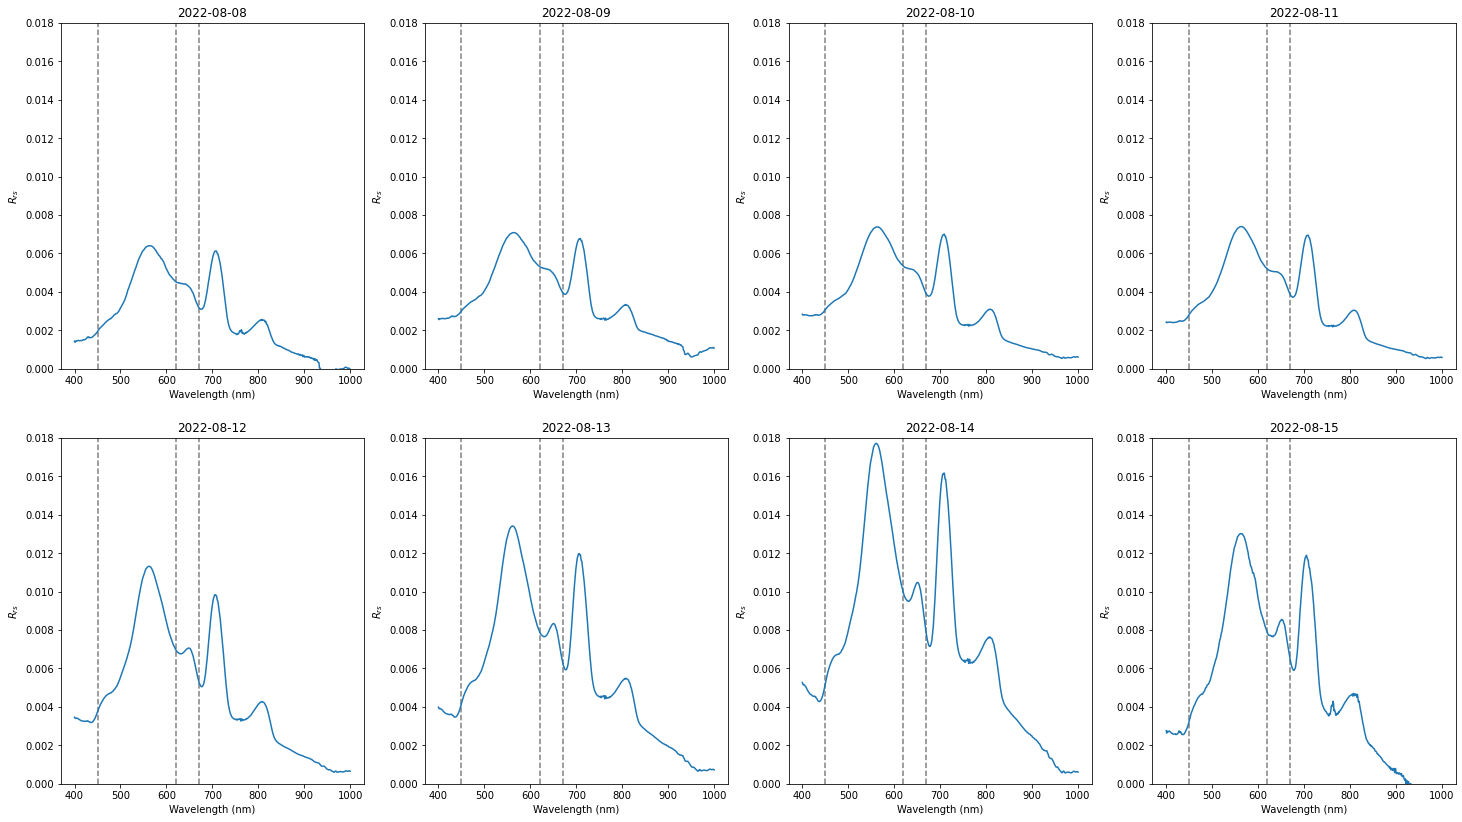

In [17]:
fig, ax = plt.subplots(2, 4, figsize=(25, 14))

ax = ax.flatten()
RHO = 0.028

for i in range(len(logList)):
    mean_spect = dalecLoad.uniform_grid_spectra_mean(logList[i], spect_wavelengths)
    
    # plot 620 nm line (P-C absorption feature) 
    ax[i].plot([620, 620], [0, 1.0], 'k--', alpha=0.5)
    ax[i].plot([680, 680], [0, 1.0], 'k--', alpha=0.5)
    ax[i].plot([450, 450], [0, 1.0], 'k--', alpha=0.5)

    
    ax[i].plot(mean_spect['Wavelength'], mean_spect['Rrs_mean'])
    ax[i].set_title(str(logList[i][' UTC Date'].iloc[0])[:10]) # using [:10] as a hacky way to not print the time lol
    ax[i].set_ylim(0, 0.018)
    ax[i].set_ylabel('$R_{rs}$')
    ax[i].set_xlabel('Wavelength (nm)')
    
    

        

plt.show()

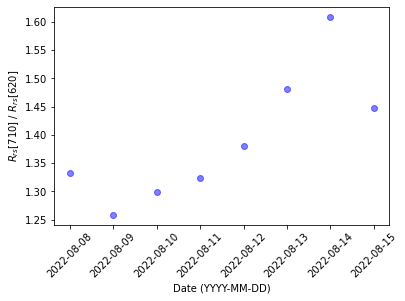

In [29]:
# looking at ratio of 620 to 710 band, as this is good for P-C detection (see Hunter, 2010)

PC_ratio = []
dates = []

for i in range(len(logList)):
    mean_spect = dalecLoad.uniform_grid_spectra_mean(logList[i], spect_wavelengths)
    y_710 = mean_spect.loc[mean_spect['Wavelength'] == 710]['Rrs_mean'].values
    y_620 = mean_spect.loc[mean_spect['Wavelength'] == 620]['Rrs_mean'].values
    PC_ratio.append(y_710/y_620)
    dates.append(str(logList[i][' UTC Date'].iloc[0])[:10])

plt.scatter(dates,PC_ratio, color='b', alpha=0.5)
plt.xticks(rotation = 45)
plt.xlabel('Date (YYYY-MM-DD)')
plt.ylabel('$R_{rs}[710]$ / $R_{rs}[620]$')
plt.show()

In [ ]:
def uniform_grid_spectra_mean(DALEC_log, spect_wavelengths, RHO=0.028, nsteps=601, min_waveL=400, max_waveL=1000):
    """
    - takes mean spectrum from an entire DALEC log file and converts to a uniform grid
    - grid is defined by nsteps, min_waveL and max_waveL
    - returns a pandas DF with Lu_mean, Lsky_mean and Ed_mean
    """

    
    # better way like this, which takes mean then does spectra regridding stuff
    #  currently not working! need to work on this some more haha
    df = DALEC_log.copy() # not sure if neccesary but perhaps best to be on the safe side?
    df.set_index('spectral_ind', append=True, inplace=True)
    df = df.groupby(level=[' Channel', 'spectral_ind']).mean(numeric_only=True)
    Lu_mean = dalecLoad.uniform_grid_spectra(df, spect_wavelengths, param='Lu', nsteps=nsteps)
    Lsky_mean = dalecLoad.uniform_grid_spectra(df, spect_wavelengths, param='Lsky', nsteps=nsteps)
    Ed_mean = dalecLoad.uniform_grid_spectra(df, spect_wavelengths, param='Ed', nsteps=nsteps)
    
    Rrs_mean = (Lu_mean[:, 1] - (RHO * Lsky_mean[:, 1])) / Ed_mean[:, 1]
    
    # might be nice to output Rrs too?
    df_out = pd.DataFrame(data={'Wavelength': Lu_mean[:, 0],
                               'Lu_mean': Lu_mean[:, 1], 
                               'Lsky_mean': Lsky_mean[:, 1],
                               'Ed_mean': Ed_mean[:, 1],
                               'Rrs_mean': Rrs_mean})
    return df_out